# Setting up kaggle to download dataset

We're gonna be using the anime face dataset from Kaggle. https://www.kaggle.com/datasets/splcher/animefacedataset

This contains 63000 images of anime characters. Visit the website for more information.

In [7]:
!pip install -q kaggle

In [8]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download splcher/animefacedataset

 98% 388M/395M [00:03<00:00, 223MB/s]
100% 395M/395M [00:03<00:00, 133MB/s]


In [11]:
!mkdir ./animefacedataset

mkdir: cannot create directory ‘./animefacedataset’: File exists


In [12]:
!unzip -q animefacedataset.zip -d ./animefacedataset

# Checking out if our dataset is correctly downloaded

In [9]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [10]:
print(os.listdir(DATA_DIR+'/images')[:10])

['13988_2006.jpg', '47837_2014.jpg', '5860_2003.jpg', '14126_2006.jpg', '59706_2018.jpg', '58084_2017.jpg', '279_2000.jpg', '16817_2007.jpg', '8841_2004.jpg', '18323_2007.jpg']


# Creating a PyTorch Dataset and DataLoader

In [11]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [12]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as transforms

In [13]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [14]:
# Creating a transform for our images
img_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*stats)  # Normalize with mean and std 0.5 for each channel
])

In [15]:
train_dataset = ImageFolder(root=DATA_DIR,
                            transform=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

In [16]:
images, _ = next(iter(train_dataloader))
images.shape, _.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

In [21]:
_.unique(), _[:10]

(tensor([0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

# Creating helper functions to denormalize images and visualize images from a training batch.

In [21]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def denorm(img_tensors):
  return img_tensors * stats[0][1] + stats[0][0]

In [69]:
def show_images(images, nmax=64):
  images = images.to('cpu')
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dataloader, nmax=64):
  images, _ = next(iter(dataloader))
  show_images(images)

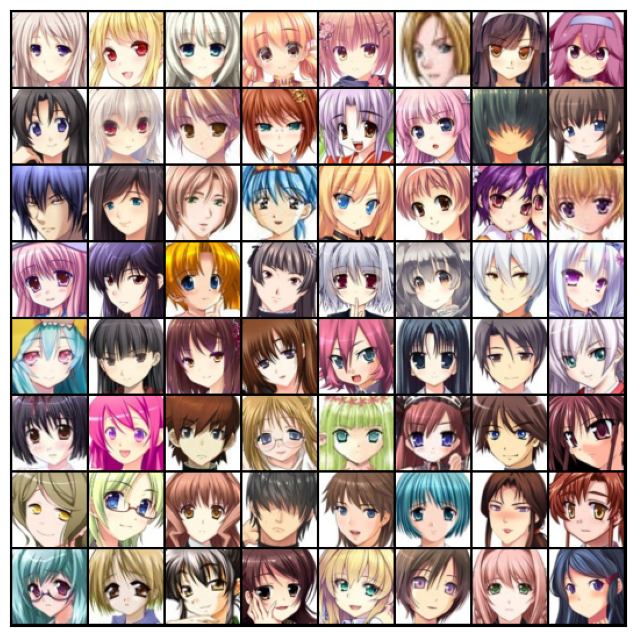

In [78]:
show_batch(train_dataloader)

# Creating the discriminator

In [91]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten()
    )

In [92]:
# Move model to target device
discriminator = discriminator.to(device)

In [93]:
# Check which device our model is on.
next(discriminator.parameters()).device

device(type='cuda', index=0)

# Creating the Generator

In [74]:
latent_size = 128

In [75]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [76]:
generator = generator.to(device)

torch.Size([128, 3, 64, 64])


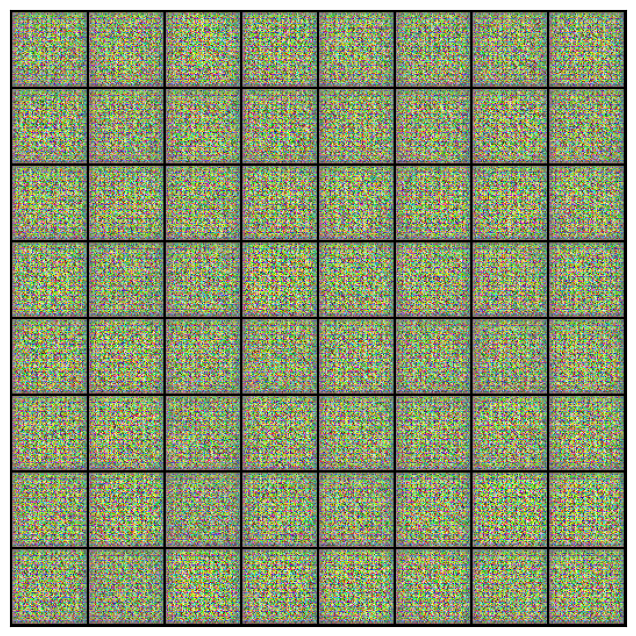

In [77]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

# Discriminator Training

In [96]:
def train_discriminator(real_images, loss_fn, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_images = real_images.to(device)
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = loss_fn(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = loss_fn(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [97]:
def train_generator(loss_fn, opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = loss_fn(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [81]:
from torchvision.utils import save_image

In [82]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [83]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [84]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


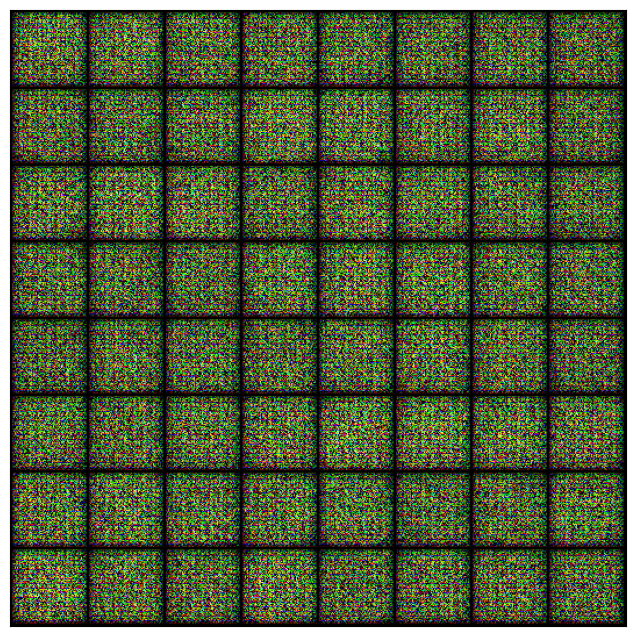

In [85]:
save_samples(0, fixed_latent)

In [86]:
from tqdm.auto import tqdm
import torch.nn

In [98]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Create loss function
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dataloader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, loss_fn, opt_d)
            # Train generator
            loss_g = train_generator(loss_fn, opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [99]:
lr = 0.0002
epochs = 25

losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.3427, loss_d: 0.5677, real_score: 0.7230, fake_score: -4.1072
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.1046, loss_d: 0.5249, real_score: 2.3391, fake_score: -1.0906
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 5.2011, loss_d: 0.2321, real_score: 2.1747, fake_score: -3.3847
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 9.1296, loss_d: 0.6832, real_score: 5.3527, fake_score: -0.4074
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 6.2487, loss_d: 0.2093, real_score: 3.4259, fake_score: -2.5832
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 8.8592, loss_d: 0.3851, real_score: 6.7337, fake_score: -1.0684
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 9.6559, loss_d: 0.3792, real_score: 7.5904, fake_score: -1.2666
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.2267, loss_d: 0.1894, real_score: 6.3698, fake_score: -2.6330
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad4c051480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad4c051480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch [9/25], loss_g: 3.6209, loss_d: 0.1970, real_score: 3.4073, fake_score: -2.7442
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad4c051480>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fad4c051480>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    
    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can on

Epoch [10/25], loss_g: 5.1741, loss_d: 0.1617, real_score: 4.6862, fake_score: -2.2844
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.0298, loss_d: 0.2191, real_score: 3.6871, fake_score: -2.1694
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 5.7924, loss_d: 0.3103, real_score: 1.7259, fake_score: -5.8440
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 1.4879, loss_d: 0.4531, real_score: 0.8685, fake_score: -5.6087
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 3.4184, loss_d: 0.2078, real_score: 2.5371, fake_score: -3.4838
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.4526, loss_d: 0.0738, real_score: 4.5897, fake_score: -3.3582
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 3.8404, loss_d: 0.2721, real_score: 2.1151, fake_score: -3.6265
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 3.3127, loss_d: 0.2170, real_score: 2.4774, fake_score: -3.4576
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 4.2372, loss_d: 0.1518, real_score: 3.8342, fake_score: -3.0189
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.9735, loss_d: 0.0384, real_score: 4.8308, fake_score: -4.5322
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.0095, loss_d: 0.2654, real_score: 3.2885, fake_score: -2.3217
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad4c051480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad4c051480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch [21/25], loss_g: 5.3702, loss_d: 0.0917, real_score: 3.4647, fake_score: -5.0570
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad4c051480>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fad4c051480>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Epoch [22/25], loss_g: 4.4741, loss_d: 0.0599, real_score: 5.0690, fake_score: -3.7901
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 2.4528, loss_d: 0.2815, real_score: 8.1871, fake_score: -1.8973
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 3.3421, loss_d: 0.0757, real_score: 3.4177, fake_score: -5.0762
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 6.9441, loss_d: 0.0569, real_score: 3.8729, fake_score: -5.8587
Saving generated-images-0025.png


([5.3426690101623535,
  5.104551315307617,
  5.201084136962891,
  9.129589080810547,
  6.248688697814941,
  8.85919189453125,
  9.655878067016602,
  4.226715564727783,
  3.6208860874176025,
  5.174069404602051,
  5.029778480529785,
  5.792407989501953,
  1.4878777265548706,
  3.41837215423584,
  4.4526472091674805,
  3.840355396270752,
  3.312744379043579,
  4.237239360809326,
  4.973505020141602,
  4.009537220001221,
  5.370150089263916,
  4.474086761474609,
  2.452826499938965,
  3.34206485748291,
  6.94411563873291],
 [0.5677086114883423,
  0.5249346494674683,
  0.232065811753273,
  0.6831920146942139,
  0.2092956006526947,
  0.385090708732605,
  0.3791847825050354,
  0.1893545538187027,
  0.19703850150108337,
  0.16167081892490387,
  0.21908241510391235,
  0.3102509081363678,
  0.45305269956588745,
  0.20777110755443573,
  0.0738249123096466,
  0.272095263004303,
  0.21701475977897644,
  0.15175959467887878,
  0.038393791764974594,
  0.26538437604904175,
  0.09166957437992096,
  0.

In [100]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [101]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

NameError: name 'losses_d' is not defined

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [102]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()